## Covariance tensor structure of Image distribution

We would like to understand the covariance structure of a gaussian mixture model. esp. are there shared variability, or are there shared null space in the mixture covariances. 

Potential routes:
* Globally decompose the batch of cov mats via tensor decomposition.
* Represent covariance matrices via a hierarchical way. locally find shared variabilities.

### Compute Batch Covariance Tensor.

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorly as tl
from tensorly.decomposition import parafac
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from tqdm import tqdm, trange

In [3]:
from sklearn.cluster import KMeans, MiniBatchKMeans
def compute_cluster_cov(Xtrain_norm, n_clusters,
                       kmeans_batch=2048, 
                       kmeans_random_seed=0,
                       kmeans_verbose=0,
                       lambda_EPS=1E-5, 
                       store_device="cuda"):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, 
            random_state=kmeans_random_seed, batch_size=kmeans_batch, verbose=kmeans_verbose)
    kmeans.fit(Xtrain_norm)
    ndim = Xtrain_norm.shape[1]
    covmats = []
    freq_col = []
    for i in trange(kmeans.n_clusters):
        n_samples = np.sum(kmeans.labels_ == i)
        X_cluster = Xtrain_norm[kmeans.labels_ == i]
        # print(i, "number of samples", n_samples)
        if n_samples == 1:
            covmat = torch.eye(ndim) * lambda_EPS
        else:
            covmat = torch.tensor(np.cov(X_cluster.T))
        covmats.append(covmat.to(store_device))
        freq_col.append(n_samples)
    covmats = torch.stack(covmats)
    freq_col = torch.tensor(freq_col).to(store_device)
    means = torch.tensor(kmeans.cluster_centers_).to(store_device)
    return kmeans, means, covmats, freq_col

In [4]:
def compute_cluster(Xtrain_norm, n_clusters,
                       kmeans_batch=2048, 
                       kmeans_random_seed=0,
                       kmeans_verbose=0,
                       lambda_EPS=1E-5, 
                       store_device="cuda"):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, 
            random_state=kmeans_random_seed, batch_size=kmeans_batch, verbose=kmeans_verbose)
    kmeans.fit(Xtrain_norm)
    print("Kmeans fitting completing, loss ", kmeans.inertia_)
    # covmats = []
    ndim = Xtrain_norm.shape[1]
    eigval_col = []
    eigvec_col = []
    freq_col = []
    for i in trange(kmeans.n_clusters):
        n_samples = np.sum(kmeans.labels_ == i)
        # print(i, "number of samples", n_samples)
        freq_col.append(n_samples)
        if n_samples == 1:
            covmat = torch.eye(ndim) * lambda_EPS
        else:
            covmat = torch.tensor(np.cov(Xtrain_norm[kmeans.labels_ == i].T))
            # PCA to reduce dimension
            covmat = covmat + lambda_EPS * torch.eye(covmat.shape[0])
        try:
            eigval, eigvec = torch.linalg.eigh(covmat.cuda())
        except:
            print(f"Singular matrix perform eigh on cpu. {n_samples} samples")
            eigval, eigvec = torch.linalg.eigh(covmat)
        
        eigval = eigval.flip(dims=(0,))  # sort from largest to smallest
        eigvec = eigvec.flip(dims=(1,))  # sort from largest to smallest
        eigval = eigval.to(store_device)
        eigvec = eigvec.to(store_device)
        eigval_col.append(eigval.cpu())
        eigvec_col.append(eigvec.cpu())
        # covmats.append(covmat)
    eigval_mat = torch.stack(eigval_col, dim=0)
    eigvec_mat = torch.stack(eigvec_col, dim=0)
    freq_vec = torch.tensor(freq_col)
    center_mat = torch.from_numpy(kmeans.cluster_centers_)
    print("cov PCA completed for each cluster.")
    return kmeans, eigval_mat, eigvec_mat, freq_vec, center_mat

In [4]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms

dataset = MNIST(root="~/Datasets", train=True, download=False, transform=transforms.ToTensor())
Xtsr = dataset.data.float() / 255
Xtrain = Xtsr.reshape(Xtsr.shape[0], -1)
ytrain = dataset.targets
Xtrain_norm = (Xtrain - Xtrain.mean()) / Xtrain.std()
Xmean = Xtrain_norm.mean(dim=0)
covmat = torch.cov((Xtrain_norm - Xmean).T)
eigval, eigvec = torch.linalg.eigh(covmat.to(torch.float64))
eigval = eigval.flip(dims=(0,))  # sort from largest to smallest
eigvec = eigvec.flip(dims=(1,))  # sort from largest to smallest
assert torch.allclose(eigvec.T @ eigvec, torch.eye(eigvec.shape[0]).to(torch.float64))
assert torch.allclose(eigvec @ torch.diag(eigval) @ eigvec.T, covmat.to(torch.float64))

In [5]:
kmeans, means, covmats, freq_col = \
    compute_cluster_cov(Xtrain_norm, 200, kmeans_batch=2048, 
                    kmeans_random_seed=0, 
                    kmeans_verbose=0, 
                    lambda_EPS=1E-5, 
                    store_device="cuda")

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
100%|██████████| 200/200 [00:01<00:00, 134.18it/s]


## Tensor Decompose batch of covariance tensors

We try to approximate a batch of covariance mats with a tensor decomposition. using tensorly library. 
* CP-decompose. 
* Tucker-decompose. 

https://tensorly.org/stable/user_guide/tensor_decomposition.html

In [ ]:
# !mamba install tensorly-torch
# https://github.com/mnick/scikit-tensor

^C


In [6]:
import tensorly as tl
from tensorly.decomposition import parafac, tucker
tl.set_backend('pytorch')

In [9]:
tl.SVD_FUNS

['truncated_svd', 'symeig_svd', 'randomized_svd']

In [11]:
torch.cuda.empty_cache()

Note the following cp decomposition is wery likely to go OOM on CPU or GPU. 
Very hard to compute, need better method.

In [15]:
# Assuming 'tensor' is your [B, N, N] tensor
factors = parafac(covmats.cpu(), rank=200, svd='truncated_svd',
                  orthogonalise=True)  # Specify the rank R
# 8mins for rank 200 on cpu... very slow.

In [18]:
tl.cp_to_tensor(factors).shape

torch.Size([200, 784, 784])

In [33]:
residues = (covmats - tl.cp_to_tensor(factors))
res_norm = torch.norm(residues, dim=(1, 2))
tot_norm = torch.norm(covmats, dim=(1, 2))
print(res_norm / tot_norm)

tensor([0.4884, 0.5888, 0.5645, 0.5313, 0.5504, 0.8157, 0.5545, 0.4625, 0.4508,
        0.4715, 0.5289, 0.5428, 0.4571, 0.7776, 0.4561, 0.4662, 0.4610, 0.5400,
        0.5214, 0.5432, 0.5797, 0.5775, 0.5425, 0.5340, 0.4984, 0.4622, 0.4455,
        0.5066, 0.6321, 0.4746, 0.5293, 0.5419, 0.8208, 0.4377, 0.5728, 0.5225,
        0.5083, 0.4264, 0.4854, 0.4599, 0.5213, 0.4910, 0.5349, 0.4530, 0.6501,
        0.5597, 0.4374, 0.5522, 0.5050, 0.4858, 0.4859, 0.5663, 0.4606, 0.5471,
        0.4382, 0.4872, 0.4856, 0.5496, 0.4832, 0.4450, 0.4236, 0.4884, 0.4733,
        0.5992, 0.5734, 0.5734, 0.4852, 0.5502, 0.7223, 0.4765, 0.4431, 0.5291,
        0.4138, 0.5052, 0.4588, 0.5076, 0.4200, 0.4662, 0.4489, 0.4694, 0.5633,
        0.4405, 0.5647, 0.5169, 0.5181, 0.4071, 0.5165, 0.4652, 0.4922, 0.5728,
        0.4893, 0.5200, 0.5997, 0.4719, 0.4387, 0.5750, 0.5190, 0.4591, 0.4533,
        0.4650, 0.4917, 0.4931, 0.4274, 0.4607, 0.5485, 0.4804, 0.8224, 0.4799,
        0.5346, 0.5397, 0.6990, 0.4918, 

In [23]:
factors.factors[1]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)

In [24]:
factors.factors[2]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)

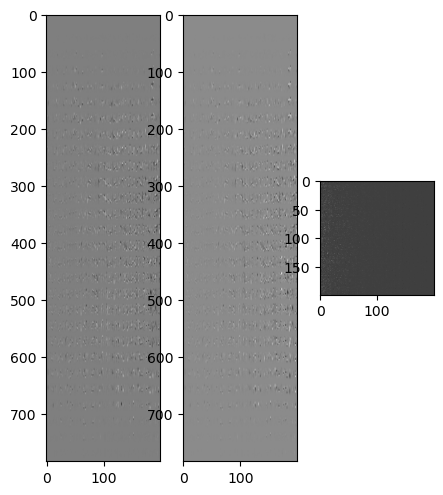

In [26]:
plt.figure(figsize=(5, 12))
plt.subplot(1, 3, 1)
plt.imshow(factors.factors[1].cpu().numpy(), cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(factors.factors[2].cpu().numpy(), cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(factors.factors[0].cpu().numpy(), cmap="gray")
plt.show()

In [22]:
res_norm

tensor([35.8247, 25.3248, 34.4893, 28.4248, 29.0011, 20.0413, 29.0605, 27.4316,
        30.1973, 33.8770, 31.0208, 34.3016, 28.1546, 19.3683, 31.4965, 27.5455,
        36.0293, 23.8977, 27.9241, 30.0404, 23.8056, 28.2789, 22.7701, 28.8336,
        32.3444, 34.3842, 28.0085, 29.7445, 27.6434, 33.1903, 24.0862, 37.5121,
        17.6189, 33.0498, 35.5646, 27.6486, 27.2951, 25.6493, 25.8692, 28.4512,
        26.6725, 35.3498, 31.6647, 30.2908, 20.0994, 33.8699, 33.5277, 35.4017,
        34.9968, 30.0374, 34.2770, 22.0280, 29.9079, 34.3714, 29.8739, 30.9392,
        28.6249, 23.6313, 34.9585, 31.6992, 25.7577, 28.5892, 34.3751, 24.3258,
        25.2107, 25.9671, 36.3276, 29.7961, 24.4627, 38.5823, 26.8239, 32.1497,
        31.4850, 31.6133, 39.2944, 37.0033, 41.4196, 40.7346, 34.4040, 27.6647,
        30.9988, 37.9349, 23.4927, 35.0668, 28.4412, 28.3888, 37.3708, 29.0317,
        26.6787, 24.3700, 27.5449, 31.0658, 25.5079, 36.7664, 33.4743, 40.2977,
        31.1824, 26.2322, 23.8458, 32.49

In [39]:
type(factors)

tensorly.cp_tensor.CPTensor

In [40]:
type(factors_tuk)

tensorly.tucker_tensor.TuckerTensor

In [9]:
def compute_params(factors):
    if isinstance(factors, tl.cp_tensor.CPTensor):
        num_params = sum([np.prod(f.shape) for f in factors.factors])
    elif isinstance(factors, tl.tucker_tensor.TuckerTensor):
        num_params = sum([np.prod(f.shape) for f in factors.factors]) + np.prod(factors.core.shape)
    return num_params


In [ ]:
factors_tuk = parafac(covmats, rank=400, verbose=0) 
print("parameter count", compute_params(factors_tuk))
residues = (covmats - tl.tucker_to_tensor(factors_tuk))
residues_norm = torch.norm(residues, dim=(1, 2))
tot_norm = torch.norm(covmats, dim=(1, 2))
print(residues_norm / tot_norm)

In [17]:
print ("X mat num of params", np.prod(Xtrain_norm.shape))
print ("cov mat num of params", np.prod(covmats.shape))

X mat num of params 47040000
cov mat num of params 122931200


In [18]:
factors_tuk = tucker(covmats, rank=(100, 300, 300), verbose=0) 
print("parameter count", compute_params(factors_tuk))
print("core shape", factors_tuk.core.shape)
print ("factor shape", [f.shape for f in factors_tuk.factors])
residues_tuk = (covmats - tl.tucker_to_tensor(factors_tuk))
residues_tuk_norm = torch.norm(residues_tuk, dim=(1, 2))
tot_norm = torch.norm(covmats, dim=(1, 2))
print(residues_tuk_norm / tot_norm)

parameter count 9490400
core shape torch.Size([100, 300, 300])
factor shape [torch.Size([200, 100]), torch.Size([784, 300]), torch.Size([784, 300])]
tensor([0.2123, 0.4805, 0.3473, 0.4111, 0.4014, 0.7132, 0.4389, 0.3644, 0.2781,
        0.2578, 0.3211, 0.3258, 0.3004, 0.6891, 0.2381, 0.2993, 0.1262, 0.4532,
        0.3811, 0.3728, 0.4401, 0.4180, 0.4459, 0.4159, 0.2808, 0.1791, 0.3148,
        0.3591, 0.4785, 0.3145, 0.4626, 0.1953, 0.7274, 0.2345, 0.2988, 0.3824,
        0.3426, 0.3551, 0.3832, 0.3119, 0.4055, 0.2465, 0.3559, 0.3042, 0.5646,
        0.3040, 0.1549, 0.2766, 0.2453, 0.3301, 0.2526, 0.5068, 0.3242, 0.2828,
        0.2696, 0.3224, 0.3438, 0.4959, 0.2525, 0.2665, 0.3455, 0.3260, 0.1918,
        0.4829, 0.4426, 0.4391, 0.2004, 0.4504, 0.5951, 0.1381, 0.3168, 0.3107,
        0.2074, 0.3355, 0.1242, 0.2248, 0.0991, 0.1405, 0.2349, 0.3617, 0.3546,
        0.1267, 0.4605, 0.2640, 0.3742, 0.2560, 0.1541, 0.3312, 0.3954, 0.4601,
        0.3464, 0.3765, 0.5077, 0.1793, 0.1620, 0.1

In [13]:
factors_tuk = tucker(covmats, rank=(200, 10, 10), verbose=0) 
print("parameter count", compute_params(factors_tuk))
print("core shape", factors_tuk.core.shape)
print ("factor shape", [f.shape for f in factors_tuk.factors])
residues_tuk = (covmats - tl.tucker_to_tensor(factors_tuk))
residues_tuk_norm = torch.norm(residues_tuk, dim=(1, 2))
tot_norm = torch.norm(covmats, dim=(1, 2))
print(residues_tuk_norm / tot_norm)

parameter count 75680
core shape torch.Size([200, 10, 10])
factor shape [torch.Size([200, 200]), torch.Size([784, 10]), torch.Size([784, 10])]
tensor([0.8191, 0.8519, 0.8984, 0.8503, 0.8625, 0.9590, 0.8822, 0.8633, 0.8790,
        0.8150, 0.8118, 0.8898, 0.8793, 0.9709, 0.8408, 0.8243, 0.9128, 0.9165,
        0.8640, 0.8990, 0.8577, 0.8996, 0.8306, 0.9184, 0.8735, 0.9061, 0.8463,
        0.8885, 0.9173, 0.8416, 0.8944, 0.9046, 0.9658, 0.8631, 0.8616, 0.8926,
        0.8999, 0.8304, 0.8554, 0.8723, 0.8634, 0.8636, 0.8327, 0.8454, 0.9028,
        0.8605, 0.8966, 0.8236, 0.8843, 0.8017, 0.8435, 0.8982, 0.8185, 0.9050,
        0.8431, 0.8843, 0.8501, 0.8390, 0.8600, 0.8109, 0.8290, 0.8661, 0.8457,
        0.8770, 0.8760, 0.8660, 0.7983, 0.8339, 0.9626, 0.8808, 0.8511, 0.8834,
        0.8653, 0.8284, 0.8525, 0.8486, 0.8819, 0.8342, 0.8207, 0.7834, 0.8997,
        0.8186, 0.8447, 0.8895, 0.8866, 0.8789, 0.8949, 0.8594, 0.8873, 0.8956,
        0.8391, 0.8890, 0.8472, 0.8190, 0.8631, 0.8667, 0

In [43]:
factors_tuk = tucker(covmats, rank=200, verbose=0) 
print("parameter count", compute_params(factors_tuk))
residues_tuk = (covmats - tl.tucker_to_tensor(factors_tuk))
residues_tuk_norm = torch.norm(residues_tuk, dim=(1, 2))
tot_norm = torch.norm(covmats, dim=(1, 2))
print(residues_tuk_norm / tot_norm)

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/tensorly/tucker_tensor.py:425: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


parameter count 8353600
tensor([0.1347, 0.1587, 0.1643, 0.1436, 0.1496, 0.2661, 0.1485, 0.1358, 0.1217,
        0.1350, 0.1738, 0.1457, 0.1463, 0.2478, 0.1460, 0.1217, 0.1410, 0.1762,
        0.1576, 0.1336, 0.1649, 0.1427, 0.1616, 0.1485, 0.1498, 0.1703, 0.1154,
        0.1362, 0.1957, 0.1373, 0.1899, 0.1462, 0.2664, 0.1228, 0.1672, 0.1194,
        0.1172, 0.1280, 0.1098, 0.1496, 0.1467, 0.1272, 0.1644, 0.1285, 0.2260,
        0.1468, 0.1402, 0.1719, 0.1396, 0.1296, 0.1509, 0.1832, 0.1299, 0.1300,
        0.1152, 0.1394, 0.1220, 0.1515, 0.1449, 0.1194, 0.1198, 0.1201, 0.1409,
        0.1794, 0.1515, 0.1316, 0.1494, 0.1660, 0.2247, 0.1453, 0.1151, 0.1231,
        0.1336, 0.1532, 0.1535, 0.1434, 0.1705, 0.1706, 0.1278, 0.1314, 0.1640,
        0.1177, 0.1465, 0.1375, 0.1507, 0.1271, 0.1400, 0.1285, 0.1343, 0.1530,
        0.1416, 0.1455, 0.1640, 0.1390, 0.1366, 0.1623, 0.1406, 0.1615, 0.1280,
        0.1276, 0.1653, 0.1582, 0.1159, 0.1389, 0.1807, 0.1359, 0.3103, 0.1551,
        0.1203, 

In [29]:
# Assuming 'tensor' is your [B, N, N] tensor
factors_tuk = tucker(covmats, rank=200, verbose=1)  # Specify the rank R

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/tensorly/tucker_tensor.py:425: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


reconstruction error=0.14582019622610604, variation=2.2933458165841358e-07.
converged in 2 iterations.


In [37]:
# number of parameters in factors_tuk 
sum([np.prod(f.shape) for f in factors.factors]) + np.prod(factors.weights.shape)

353800

In [36]:
# number of parameters in factors_tuk 
sum([np.prod(f.shape) for f in factors_tuk.factors]) + np.prod(factors_tuk.core.shape)

8353600

In [30]:
factors_tuk.core.shape

torch.Size([200, 200, 200])

In [31]:
factors_tuk.factors[0].shape

torch.Size([200, 200])

In [32]:
residues_tuk = (covmats - tl.tucker_to_tensor(factors_tuk))
residues_tuk_norm = torch.norm(residues_tuk, dim=(1, 2))
tot_norm = torch.norm(covmats, dim=(1, 2))
print(residues_tuk_norm / tot_norm)

tensor([0.1347, 0.1587, 0.1643, 0.1436, 0.1496, 0.2661, 0.1485, 0.1358, 0.1217,
        0.1350, 0.1738, 0.1457, 0.1463, 0.2478, 0.1460, 0.1217, 0.1410, 0.1762,
        0.1576, 0.1336, 0.1649, 0.1427, 0.1616, 0.1485, 0.1498, 0.1703, 0.1154,
        0.1362, 0.1957, 0.1373, 0.1899, 0.1462, 0.2664, 0.1228, 0.1672, 0.1194,
        0.1172, 0.1280, 0.1098, 0.1496, 0.1467, 0.1272, 0.1644, 0.1285, 0.2260,
        0.1468, 0.1402, 0.1719, 0.1396, 0.1296, 0.1509, 0.1832, 0.1299, 0.1300,
        0.1152, 0.1394, 0.1220, 0.1515, 0.1449, 0.1194, 0.1198, 0.1201, 0.1409,
        0.1794, 0.1515, 0.1316, 0.1494, 0.1660, 0.2247, 0.1453, 0.1151, 0.1231,
        0.1336, 0.1532, 0.1535, 0.1434, 0.1705, 0.1706, 0.1278, 0.1314, 0.1640,
        0.1177, 0.1465, 0.1375, 0.1507, 0.1271, 0.1400, 0.1285, 0.1343, 0.1530,
        0.1416, 0.1455, 0.1640, 0.1390, 0.1366, 0.1623, 0.1406, 0.1615, 0.1280,
        0.1276, 0.1653, 0.1582, 0.1159, 0.1389, 0.1807, 0.1359, 0.3103, 0.1551,
        0.1203, 0.1900, 0.2438, 0.1579, 